In [32]:
# MEDICIONES SOBRE TIERRA

In [33]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import stats

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from varname import nameof
import os

In [34]:
%run check_import.ipynb
%run codigos/transformada.ipynb
%run codigos/to_baseband.ipynb
%run codigos/FFT_ordenada.ipynb
%run codigos/to_dB.ipynb
%run codigos/mv_to_ep.ipynb
%run codigos/R_Fresnel.ipynb

In [35]:
#-----------------------------------
## Parámetros globales de la antena
#-----------------------------------

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 
corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

#------------------------------
#Elegir frecuencia portadora
#------------------------------
portadora = input('portadora? (Fc7 o Fc8)')

if portadora == 'Fc7':
    fc = 7.290e9 
    Fc = '7.29GHz'
elif portadora == 'Fc8':
    fc = 8.748e9
    Fc = '8.74GHz'
else:
    print('Error: portadora debe ser Fc7 o Fc8')


#------------------------------
# Elegir sistema operativo
#------------------------------
#system = 'ubuntu'
#system = 'windows'


## Mediciones S1 vs S2

In [36]:
date = ['mediciones_05_27', 'mediciones_06_09', 'mediciones_07_15', 'mediciones_08_22']
path = []
for i in range(len(date)):
    path.append(os.path.join(sys.path[0],date[i]))
# print(path)
# print(type(path[0]))


In [37]:
#-------------------------------------------------
#Check-importing data
#-------------------------------------------------
#funcion :Check_import((Path, target, portadora):
'''
Funcion que chequea numero de mediciones y long. Importa datos
Inputs:
Path = path donde estan las mediciones
Portadora = Fc8 o Fc7
target = (S1, S2, M2, X2) o (Z2, MZ2)

Output:
[0]:h = alturas de las mediciones
[1]:S = devuelve el vector segun lo que import
-solo para Z2 o MZ2-
[2]tita = angulo de incidencia (si es dif a 0)
'''

'\nFuncion que chequea numero de mediciones y long. Importa datos\nInputs:\nPath = path donde estan las mediciones\nPortadora = Fc8 o Fc7\ntarget = (S1, S2, M2, X2) o (Z2, MZ2)\n\nOutput:\n[0]:h = alturas de las mediciones\n[1]:S = devuelve el vector segun lo que import\n-solo para Z2 o MZ2-\n[2]tita = angulo de incidencia (si es dif a 0)\n'

# mayo

In [44]:
print('-----')
print('S1-mayo')
print('-----')
h1_may, S1_may = check_import(path[0], 'S1', portadora)
print('-----')
print('S2-mayo')
print('-----')
h2_may, S2_may = check_import(path[0], 'S2', portadora)

#los d son todos iguales (1.8-3m)
d1 = S1_may[0,0,:,0]
d2 = S2_may[0,0,:,0]

if np.array_equal(d1,d2) == True:
    d = d1


-----
S1-mayo
-----
altura = 0.37
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.465
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.66
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.865
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

-----
S2-mayo
-----
altura = 0.365
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.47
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.665
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

altura = 0.865
# mediciones = 10
[285 285 285 285 285 285 285 285 285 285]
iguales, importo datos!!

[0.18000001 0.18645277 0.19290553 0.19935829 0.20581106 0.21226382
 0.21871658 0.22516934 0.2316221  0.23807487 0.24452763 0.25098039
 0.25743315 0.2638859

In [45]:
#------------------------------------
#transformada
#------------------------------------
#funcion: transformada(señal,fc,Nfft,Ts,name)
'''

'''
#la frecuencia depende de Nfft y ademas la estoy cortando, asi 
#que es igual para todas
f1 = transformada(S1_may[0,:,:,:],fc,Nfft,Ts)[0]

#-------------------------MAYO----------------------------
S1_may_fft = np.zeros((len(h1_may),len(f1)),dtype=complex)
for j in range(len(h1_may)):
    S = S1_may[j,:,:,:]
    S1_may_fft[j,:] = transformada(S,fc,Nfft,Ts)[1]
    
print(S1_may_fft)


# #-------------------------JUNIO---------------------------
# S1_jun_fft = np.zeros((len(h1_jun),len(f1)),dtype=complex)

# for j in range(len(h1_jun)):
#     S1_jun_fft[j,:] = transformada(S1_jun[j,:,:,:],fc,Nfft,Ts)[1]

# #-------------------------JULIO---------------------------
# S1_jul_fft = np.zeros((len(h1_jul),len(f1)),dtype=complex)

# for j in range(len(h1_jul)):
#     S1_jul_fft[j,:] = transformada(S1_jul[j,:,:,:],fc,Nfft,Ts)[1]

# #-------------------------AGOSTO---------------------------
# S1A_ag_fft = np.zeros((len(h1_ag),len(f1)),dtype=complex)
# S1B_ag_fft = np.zeros((len(h1_ag),len(f1)),dtype=complex)

# for j in range(len(h1_ag)):
#     S1A_ag_fft[j,:] = transformada(S1A_ag[j,:,:,:],fc,Nfft,Ts)[1]
#     S1B_ag_fft[j,:] = transformada(S1B_ag[j,:,:,:],fc,Nfft,Ts)[1]


[[-2.15331597e-03-1.43108421e-02j -2.24178669e-03-1.55101393e-02j
  -2.47126377e-03-1.72212242e-02j -3.37619697e-03-1.92319225e-02j
  -5.03859581e-03-2.10204507e-02j -7.12118651e-03-2.22431614e-02j
  -9.24180471e-03-2.30577342e-02j -1.16616156e-02-2.37657677e-02j
  -1.48192083e-02-2.36887872e-02j -1.76111291e-02-2.18185364e-02j
  -1.81655121e-02-1.93221293e-02j -1.72300585e-02-1.88557975e-02j
  -1.78373056e-02-2.03916159e-02j -2.06320169e-02-2.10351790e-02j
  -2.32054624e-02-1.98482228e-02j -2.48167950e-02-1.87947115e-02j
  -2.73892941e-02-1.81947464e-02j -3.10986786e-02-1.57912916e-02j
  -3.34686501e-02-1.10362303e-02j -3.34065203e-02-6.04378845e-03j
  -3.21875284e-02-2.03044481e-03j -3.05609147e-02+1.53752389e-03j
  -2.82557753e-02+4.75625329e-03j -2.55786502e-02+7.30264799e-03j
  -2.28839678e-02+9.61844496e-03j -1.96786549e-02+1.20108120e-02j
  -1.56902815e-02+1.40297791e-02j -1.11369842e-02+1.55251176e-02j
  -5.80283641e-03+1.64394324e-02j  1.53166154e-04+1.60851827e-02j
   5.71423

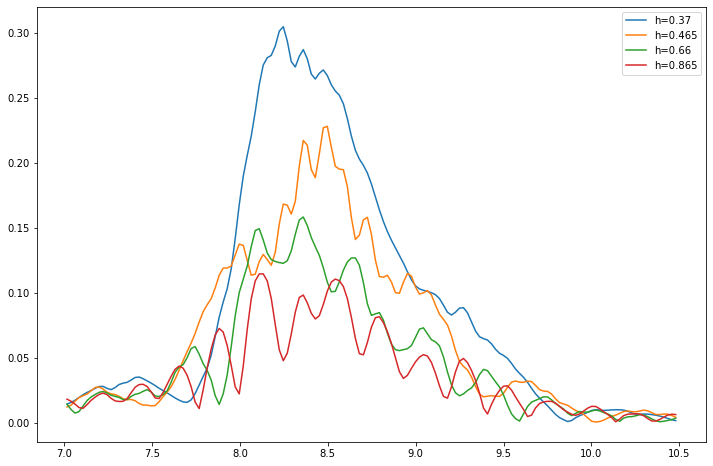

In [46]:
plt.figure(figsize=(12,8))
for i in range(len(h1_may)):
    plt.plot(f1,np.abs(S1_may_fft[i,:]),label='h='+str(h1_may[i]))
    plt.legend()


me armo un diccionario

In [41]:
Mayo = {
    'h1_may' : h2_may,
    'h2_may' : h2_may,
    'f1' : f1,
    'f2' : f2,
    'S1_may' : S1_may_fft,
    'S2_may' : S2_may_fft,
}

NameError: name 'f2' is not defined

In [ ]:
# # load pickle module
# import pickle

# # create a binary pickle file 
# f = open("S1.pkl","wb") #Wb : write binary

# # write the python object (dict) to pickle file
# pickle.dump(S1,f)

# # close file
# f.close()

In [ ]:
h1_jun, S1_jun = check_import(path[1], 'S1', portadora)
h1_jul, S1_jul = check_import(path[2], 'S1', portadora)
h1_ag, S1A_ag = check_import(path[3], 'S1A', portadora)
S1B_ag = check_import(path[3], 'S1B', portadora)[1]
h2_jun, S2_jun = check_import(path[1], 'S2', portadora)
h2_jul, S2_jul = check_import(path[2], 'S2', portadora)
h2_ag, S2_ag = check_import(path[3], 'S2', portadora)

#https://researchdatapod.com/how-to-solve-python-attributeerror-str-object-has-no-attribute-read/#:~:text=DSA-,How%20to%20Solve%20Python%20AttributeError%3A%20'str',object%20has%20no%20attribute%20'read'&text=This%20error%20typically%20occurs%20when,or%20reading%20a%20file%20object.